# AUV dataset:

### 132143 - 125355 - 113610 - 105317 - 104728. This are the only set containing annotated images all obtained at 01/05/2018

# Structure

#1 is a experiment using only 132143 dataset (around 400 images for training and 100 for validation) it is tested without augmentation (1.1) and with (1.2).

#2 is a experiment using all the dataset together (1709 training and 427 validation). Without data augmentation (2.1), with (2.2), with augmentation and changing pixel size instead of 64x64 to 256x256 (2.3), the conditions of 2.2 but not rescaling/normalizing the RGB channel values in the model (2.4), For (2.5) the conditions of 2.2 but using autokeras model.

#3 is a experiment with transfer learning. We reuse parts of an already trained model(using MobileNet v2) and change the final layer of the model, and then retrain those layers on our own dataset. The partial model from TensorFlow Hub is a feature_extractor. The reasoning for this term is that it will take the input all the way to a layer containing a number of features. So it has done the bulk of the work in identifying the content of an image, except for creating the final probability distribution. That is, it has extracted the features of the image. We also freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer. 3.2 (GG (VGG16 or VGG19), GoogLeNet (InceptionV3), Residual Network (ResNet50).

#4 convert a Keras model into a TensorFlow Lite model. Once saved, we can load it and use it to calculate the inference on some new input. Keras supports saving a single HDF5 file containing the model's architecture, weights values, and compile() information. It is a light-weight alternative to SavedModel. It loses External losses & metrics and computation graph of custom objects.
# To train a model fast we should look to 4.2 section and substitute the code appropriately.


#5 Is a explanation on the architecture of the system as a whole.

# Conclusions

For #1 its clear the model overfits, training accuracy is near 100% but the validation accuracy goes around 88% and its loss around 40%. When applying augmentation the training accuracy drop to 80 to 85% and the validation stays slightly better with lower loss. Overall we can see that the model is more prepared this way to deal with a new set of images this way, but at the same time one would expect better accuracy in the validation and/or the training set, this can mean there is not enough data.

For #2 the same principle applies to 2.1 and 2.2, it overfits in the first having 100 and 92 accuracy for training and validation, once augmentated values drop to 93 and 95, this still seems like good results, the fact of the validation set having better accuracy than training can be due to the performance is measured at the end of the epoch, but training performance is the average values across the epoch. Also the network is still performing image augmentation on the training images, but not on the validation dataset. This means the training images may be harder to classify compared to the normal images in the validation dataset. For 2.3 one thought is explored, the original images have resolutions of 1376x1032 pixels, are we not losing information by scaling the image to 64x64 pixels? From the results 87 and 90 it even performs worse with more information and is more slow fitting (with 1024x1024 it is extremely slow). For 2.4 is explored the concept of normalizing the images (image_gen = ImageDataGenerator(rescale=1./255)) to the range 0-1 preferred for neural network models. The worst obtained results were obtained by not normalizing the images 85 and 88 with around 50% loss. For 2.5 autokeras is used, using all 80% of 1700 images to training and 20% for validation, obtaining 99% accuracy which seems like overfitting. Using the val directory (unseen images representing test set) we obtained a random prediction of 90% which is good.

#3 As for transfer learning it obtained bad results, 72% and 63% accuracy. The same code was applied for another example (cats or dogs) which obtained accuracy of 97% and a bit less for validation. This was likely because the model was trained with classifying species of dogs, and so it performed better on classifying if it is a dog or not. Maybe out of the 1000 output classes none is similar to AUV photos and so it gives poor performace.

#4 It's fairly simple to convert/save/load these models for tflite and then use them on a mobile device. 4.1 to test different types execution time

#5 Overall dependencies that are used, explained more detailed followed by the main program details.

In [1]:
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import random
import os
import numpy as np
import glob
import shutil
import pandas as pd
from sklearn.utils import shuffle
from PIL import Image

import autokeras as ak
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from sklearn.metrics import *
from tensorflow.keras.applications.vgg16 import VGG16
import time
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix

# #1- 01/05/2018 - Eunis level 2 example (A3,A4,A5)
Since most of the EUNIS level 1 examples are almost if not all from 1 class, it makes more sense to use more specific levels to have more classes. 

Here all the images are mixed up, looking into the CSV a lot of them are not classified so they shouldn't be considered in the model.

The code below creates a train and a val folder each containing 3 folders (one for each type of level 2 classification). It then moves the images from the original folders to these new folders such that 80% of the images go to the training set and 20% of the images go into the validation set. In the end our directory will have the following structure:

In [2]:
def organize_Folder(base_dir,df,classes):
    tuples = [tuple(x) for x in df.values]
    #print(tuples)
    #print(df.columns[8])

    for i in tuples:
        if(str(i[8]) != "nan"):
            if os.path.exists(os.path.join(base_dir, str(i[8]), str(i[0]))):
                     continue
            if not os.path.exists(os.path.join(base_dir, str(i[8]))):
                os.makedirs(os.path.join(base_dir, str(i[8])))
            shutil.move((base_dir + str(i[0])), os.path.join(base_dir, str(i[8])))

    for cl in classes:    
        img_path = os.path.join(base_dir, cl)
        images = glob.glob(img_path + '/*.jpg')
        random.shuffle(images)
        print("{}: {} Images".format(cl, len(images)))
        num_train = int(round(len(images)*0.8))
        train, val = images[:num_train], images[num_train:]

        for t in train:
            if not os.path.exists(os.path.join(base_dir, 'train', cl)):
                os.makedirs(os.path.join(base_dir, 'train', cl))
            shutil.move(t, os.path.join(base_dir, 'train', cl))

        for v in val:
            if not os.path.exists(os.path.join(base_dir, 'val', cl)):
                os.makedirs(os.path.join(base_dir, 'val', cl))
            shutil.move(v, os.path.join(base_dir, 'val', cl))
    
base_dir = "/home/miguel/Desktop/AUV_dataset/01-05-18/"
classes = ['A3', 'A4', 'A5']

df = pd.read_csv('/home/miguel/Desktop/AUV_dataset/fotos-anotadas/132143_forcadinho-np3-targets.csv', sep=',')
organize_Folder(base_dir,df,classes)
df = pd.read_csv('/home/miguel/Desktop/AUV_dataset/fotos-anotadas/125355_forcadinho-np3-targets - cópia 2.csv', sep=',')
organize_Folder(base_dir,df,classes)
df = pd.read_csv('/home/miguel/Desktop/AUV_dataset/fotos-anotadas/113610_cam_survey_1-targets - cópia.csv', sep=',')
organize_Folder(base_dir,df,classes)
df = pd.read_csv('/home/miguel/Desktop/AUV_dataset/fotos-anotadas/105317_cam-np3-targets - cópia.csv', sep=',')
organize_Folder(base_dir,df,classes)
df = pd.read_csv('/home/miguel/Desktop/AUV_dataset/fotos-anotadas/104728_cam-np3-targets 20.27.05.csv', sep=',')
organize_Folder(base_dir,df,classes)

NameError: name 'pd' is not defined

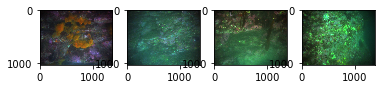

In [12]:
def showSamples():
    img_folder=base_dir+'train/A3'
    for i in range(4):
        file = random.choice(os.listdir(img_folder))
        image_path= os.path.join(img_folder, file)
        img=mpimg.imread(image_path)
        ax=plt.subplot(1,4,i+1)
        ax.title.set_text(image_path[95:-4])
        plt.imshow(img)

showSamples()

# 1.1 - Without Augmentation (132143_Forcadinho-np3)

In [6]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

batch_size = 32
IMG_SHAPE = 64

image_gen = ImageDataGenerator(rescale=1./255)

train_data_gen = image_gen.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )
val_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 1709 images belonging to 3 classes.
Found 427 images belonging to 3 classes.


In [13]:
model = Sequential()

model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(3))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 50

history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

Epoch 1/50
13/13 [==============================] - 4s 271ms/step - loss: 1.0528 - accuracy: 0.4638 - val_loss: 1.0090 - val_accuracy: 0.4900
Epoch 2/50
13/13 [==============================] - 3s 239ms/step - loss: 0.9639 - accuracy: 0.5062 - val_loss: 0.8497 - val_accuracy: 0.6200
Epoch 3/50
13/13 [==============================] - 3s 241ms/step - loss: 0.8754 - accuracy: 0.5736 - val_loss: 0.8040 - val_accuracy: 0.6500
Epoch 4/50
13/13 [==============================] - 3s 238ms/step - loss: 0.7487 - accuracy: 0.6509 - val_loss: 0.7557 - val_accuracy: 0.6200
Epoch 5/50
13/13 [==============================] - 3s 243ms/step - loss: 0.7559 - accuracy: 0.6608 - val_loss: 0.7745 - val_accuracy: 0.6000
Epoch 6/50
13/13 [==============================] - 3s 243ms/step - loss: 0.7930 - accuracy: 0.6484 - val_loss: 0.7291 - val_accuracy: 0.6400
Epoch 7/50
13/13 [==============================] - 3s 251ms/step - loss: 0.6863 - accuracy: 0.7057 - val_loss: 0.6481 - val_accuracy: 0.7500
Epoch 

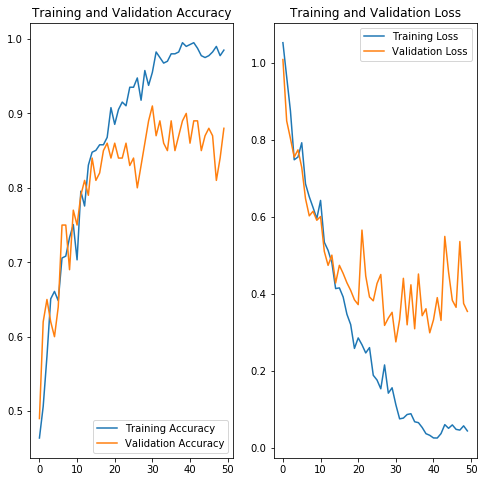

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 1.2 - Same mode with Data Augmentation

In [15]:
image_gen = ImageDataGenerator(rescale=1./255)
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )
val_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

Found 401 images belonging to 3 classes.
Found 100 images belonging to 3 classes.
Epoch 1/50
13/13 [==============================] - 4s 287ms/step - loss: 1.0916 - accuracy: 0.6135 - val_loss: 0.4953 - val_accuracy: 0.7900
Epoch 2/50
13/13 [==============================] - 4s 270ms/step - loss: 0.8185 - accuracy: 0.6334 - val_loss: 0.6060 - val_accuracy: 0.7900
Epoch 3/50
13/13 [==============================] - 3s 265ms/step - loss: 0.7321 - accuracy: 0.6683 - val_loss: 0.5383 - val_accuracy: 0.7300
Epoch 4/50
13/13 [==============================] - 3s 267ms/step - loss: 0.6309 - accuracy: 0.7182 - val_loss: 0.4627 - val_accuracy: 0.7900
Epoch 5/50
13/13 [==============================] - 3s 261ms/step - loss: 0.5792 - accuracy: 0.7531 - val_loss: 0.4929 - val_accuracy: 0.7800
Epoch 6/50
13/13 [==============================] - 3s 259ms/step - loss: 0.5663 - accuracy: 0.7631 - val_loss: 0.4283 - val_accuracy: 0.8000
Epoch 7/50
13/13 [==============================] - 3s 267ms/step 

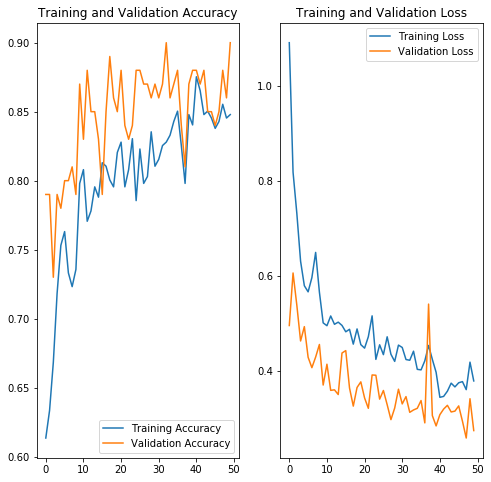

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

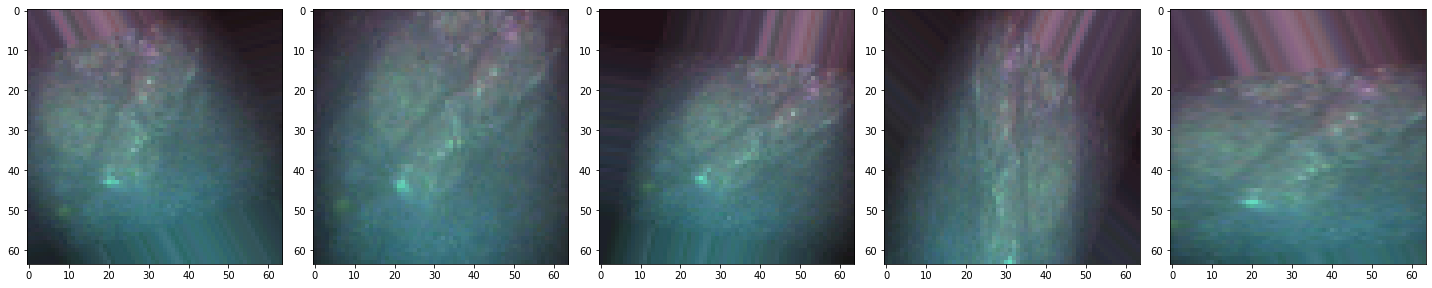

In [30]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

# 2.1 - Merging all datasets

In [4]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

batch_size = 32
IMG_SHAPE = 64

image_gen = ImageDataGenerator(rescale=1./255)

train_data_gen = image_gen.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )
val_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 1709 images belonging to 3 classes.
Found 427 images belonging to 3 classes.


In [5]:
model = Sequential()

model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(3))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 50

history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

Epoch 1/50
54/54 [==============================] - 25s 459ms/step - loss: 0.8995 - accuracy: 0.6349 - val_loss: 0.8388 - val_accuracy: 0.6393
Epoch 2/50
54/54 [==============================] - 31s 573ms/step - loss: 0.7057 - accuracy: 0.7010 - val_loss: 0.6017 - val_accuracy: 0.7424
Epoch 3/50
54/54 [==============================] - 24s 444ms/step - loss: 0.5357 - accuracy: 0.7812 - val_loss: 0.4419 - val_accuracy: 0.8009
Epoch 4/50
54/54 [==============================] - 23s 435ms/step - loss: 0.4869 - accuracy: 0.7905 - val_loss: 0.4171 - val_accuracy: 0.8314
Epoch 5/50
54/54 [==============================] - 25s 455ms/step - loss: 0.4272 - accuracy: 0.8075 - val_loss: 0.4163 - val_accuracy: 0.8384
Epoch 6/50
54/54 [==============================] - 27s 496ms/step - loss: 0.3774 - accuracy: 0.8490 - val_loss: 0.3936 - val_accuracy: 0.8431
Epoch 7/50
54/54 [==============================] - 25s 467ms/step - loss: 0.3565 - accuracy: 0.8672 - val_loss: 0.3464 - val_accuracy: 0.8735

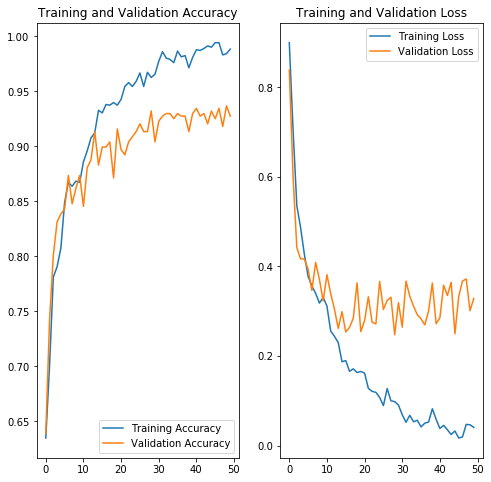

In [6]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 2.2 - All Dataset With Data Augmentation

In [7]:
image_gen = ImageDataGenerator(rescale=1./255)
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )
val_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

epochs = 100
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

Found 1709 images belonging to 3 classes.
Found 427 images belonging to 3 classes.
Epoch 1/100
54/54 [==============================] - 26s 478ms/step - loss: 0.7935 - accuracy: 0.7127 - val_loss: 0.4233 - val_accuracy: 0.8314
Epoch 2/100
54/54 [==============================] - 26s 483ms/step - loss: 0.5448 - accuracy: 0.7695 - val_loss: 0.3970 - val_accuracy: 0.8244
Epoch 3/100
54/54 [==============================] - 27s 508ms/step - loss: 0.5217 - accuracy: 0.7882 - val_loss: 0.3756 - val_accuracy: 0.8454
Epoch 4/100
54/54 [==============================] - 28s 514ms/step - loss: 0.4808 - accuracy: 0.7970 - val_loss: 0.3459 - val_accuracy: 0.8665
Epoch 5/100
54/54 [==============================] - 25s 472ms/step - loss: 0.4754 - accuracy: 0.8057 - val_loss: 0.3371 - val_accuracy: 0.8548
Epoch 6/100
54/54 [==============================] - 22s 406ms/step - loss: 0.4467 - accuracy: 0.8005 - val_loss: 0.2927 - val_accuracy: 0.8899
Epoch 7/100
54/54 [==============================] - 

Epoch 57/100
54/54 [==============================] - 26s 489ms/step - loss: 0.2335 - accuracy: 0.9011 - val_loss: 0.2482 - val_accuracy: 0.9180
Epoch 58/100
54/54 [==============================] - 26s 490ms/step - loss: 0.2386 - accuracy: 0.9017 - val_loss: 0.2199 - val_accuracy: 0.9321
Epoch 59/100
54/54 [==============================] - 27s 493ms/step - loss: 0.2359 - accuracy: 0.9122 - val_loss: 0.2042 - val_accuracy: 0.9438
Epoch 60/100
54/54 [==============================] - 26s 486ms/step - loss: 0.2712 - accuracy: 0.8912 - val_loss: 0.1868 - val_accuracy: 0.9438
Epoch 61/100
54/54 [==============================] - 27s 506ms/step - loss: 0.2158 - accuracy: 0.9169 - val_loss: 0.2129 - val_accuracy: 0.9391
Epoch 62/100
54/54 [==============================] - 27s 497ms/step - loss: 0.2252 - accuracy: 0.9175 - val_loss: 0.2297 - val_accuracy: 0.9321
Epoch 63/100
54/54 [==============================] - 27s 502ms/step - loss: 0.2274 - accuracy: 0.9081 - val_loss: 0.2041 - val_ac

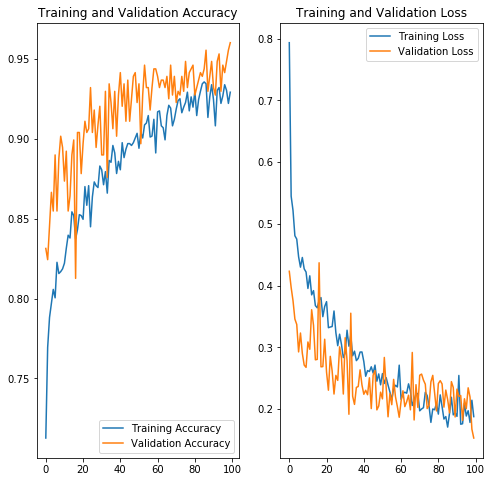

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 2.3 - All dataset with image size to 256x256 pixels

In [7]:
IMG_SHAPE = 256
batch_size = 32
image_gen = ImageDataGenerator(rescale=1./255)
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )
val_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

model = Sequential()

model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(3))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 50
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

Found 1709 images belonging to 3 classes.
Found 427 images belonging to 3 classes.
Epoch 1/50
54/54 [==============================] - 95s 2s/step - loss: 1.0438 - accuracy: 0.6238 - val_loss: 0.7989 - val_accuracy: 0.6464
Epoch 2/50
54/54 [==============================] - 93s 2s/step - loss: 0.7562 - accuracy: 0.6665 - val_loss: 0.6154 - val_accuracy: 0.7471
Epoch 3/50
54/54 [==============================] - 91s 2s/step - loss: 0.6835 - accuracy: 0.7215 - val_loss: 0.5747 - val_accuracy: 0.7939
Epoch 4/50
54/54 [==============================] - 94s 2s/step - loss: 0.6265 - accuracy: 0.7443 - val_loss: 0.5485 - val_accuracy: 0.7939
Epoch 5/50
54/54 [==============================] - 92s 2s/step - loss: 0.6347 - accuracy: 0.7396 - val_loss: 0.5245 - val_accuracy: 0.7799
Epoch 6/50
54/54 [==============================] - 92s 2s/step - loss: 0.5711 - accuracy: 0.7624 - val_loss: 0.5438 - val_accuracy: 0.7611
Epoch 7/50
54/54 [==============================] - 92s 2s/step - loss: 0.560

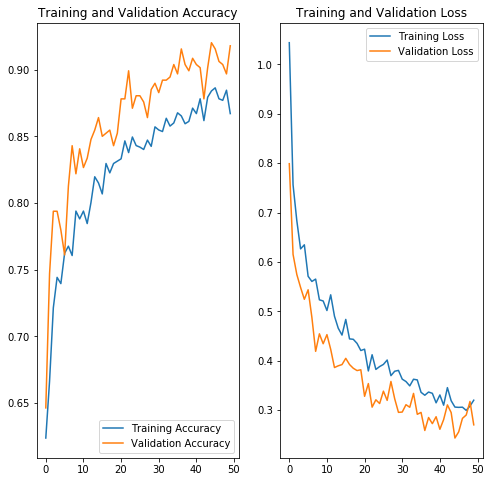

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 2.4 - All dataset with no RGB channel rescaling

In [9]:
IMG_SHAPE = 64
batch_size = 32
image_gen = ImageDataGenerator()
image_gen_train = ImageDataGenerator(
                    rotation_range=45,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )
val_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

model = Sequential()

model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(3))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 50
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

Found 1709 images belonging to 3 classes.
Found 427 images belonging to 3 classes.
Epoch 1/50
54/54 [==============================] - 20s 375ms/step - loss: 4.7612 - accuracy: 0.5857 - val_loss: 0.8202 - val_accuracy: 0.6393
Epoch 2/50
54/54 [==============================] - 20s 369ms/step - loss: 0.7838 - accuracy: 0.6583 - val_loss: 0.6750 - val_accuracy: 0.6768
Epoch 3/50
54/54 [==============================] - 22s 404ms/step - loss: 0.7064 - accuracy: 0.6875 - val_loss: 0.6705 - val_accuracy: 0.7330
Epoch 4/50
54/54 [==============================] - 26s 480ms/step - loss: 0.6259 - accuracy: 0.7314 - val_loss: 0.5513 - val_accuracy: 0.7869
Epoch 5/50
54/54 [==============================] - 26s 475ms/step - loss: 0.5966 - accuracy: 0.7478 - val_loss: 0.5998 - val_accuracy: 0.7096
Epoch 6/50
54/54 [==============================] - 26s 486ms/step - loss: 0.5782 - accuracy: 0.7554 - val_loss: 0.4600 - val_accuracy: 0.7916
Epoch 7/50
54/54 [==============================] - 26s 481

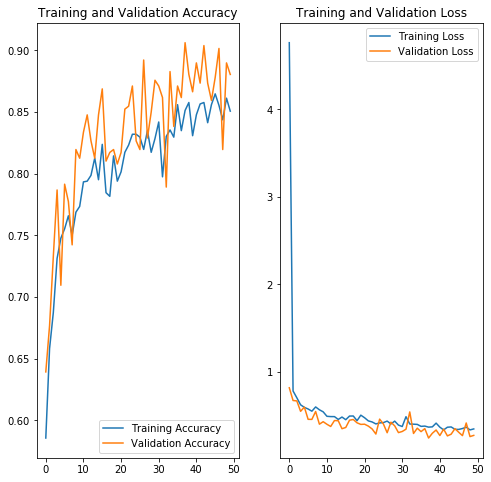

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 2.5 - All Dataset with Autokeras

In [2]:
base_dir = "/home/miguel/Desktop/AUV_dataset/01-05-18/"
classes = ['A3', 'A4', 'A5']
def img2array(img_file):
    """
    Opens the image and and converts it to a normalized array
    """
    img = Image.open(img_file)
    img = img.convert('RGB')
    img = img.resize((64,64))
    img_array = np.asarray(img)/255
    #img_array = tf.expand_dims(img_array, 0)
 
    return img_array
 
def create_dataset(path):
    """
    Goes through the list of folders (each corresponding to 1 different class)
    under 'path' and generates a numpy dataset for ML training.
    """
    folders = glob.glob(path+"/*/")
    print("Found",len(folders),"folders under",path)
    count = 0
    for folder in folders:
        print (count,":", os.path.basename(os.path.dirname(folder)))
        count = count + 1
 
    #create (initially empty) dataframe
    all_data = pd.DataFrame()
    
    count = 0
    for folder in folders:
        folder_data = pd.DataFrame()
        folder_name = os.path.basename(os.path.dirname(folder))
        folder_imgs = glob.glob(folder+'/*.jpg')
        folder_data['image'] = [x for x in folder_imgs]
        folder_data['outcome'] = count
        all_data = pd.concat([all_data, folder_data], axis = 0, ignore_index = True)
        count = count + 1
    #shuffle all the data
    all_data = shuffle(all_data)
    print(len(all_data))
    #convert dataframe into numpy arrays
    X = np.array([img2array(img) for img in all_data.image.values])
    y = all_data.outcome.values
    return X, y
        
X, y = create_dataset(base_dir + "train")
print("end")

Found 3 folders under /home/miguel/Desktop/AUV_dataset/01-05-18/train
0 : A5
1 : A3
2 : A4
1709
end


In [3]:
tf.keras.backend.set_floatx('float64')
clf = ak.ImageClassifier(
    metrics='accuracy',
    max_trials=1)
    
history = clf.fit(x = X, y = y, epochs = 50, validation_split = 0.2)
 
# Predict with the best model.
predicted_y = clf.predict(X)
print(predicted_y)

# Evaluate the best model with testing data.
print(clf.evaluate(X, y))

INFO:tensorflow:Reloading Oracle from existing project ./image_classifier/oracle.json
INFO:tensorflow:Reloading Tuner from ./image_classifier/tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
54/54 [==============================] - 37s 687ms/step - loss: 0.7390 - accuracy: 0.7010
Epoch 2/50
54/54 [==============================] - 38s 712ms/step - loss: 0.5139 - accuracy: 0.7888
Epoch 3/50
54/54 [==============================] - 37s 693ms/step - loss: 0.4099 - accuracy: 0.8408
Epoch 4/50
54/54 [==============================] - 37s 693ms/step - loss: 0.3286 - accuracy: 0.8789
Epoch 5/50
54/54 [==============================] - 30s 554ms/step - loss: 0.2446 - accuracy: 0.9134
Epoch 6/50
54/54 [==============================] - 32s 595ms/step - loss: 0.2187 - accuracy: 0.9193
Epoch 7/50
54/54 [==============================] - 33s 619ms/step - loss: 0.2008 - accuracy: 0.9292
Epoch 8/50
54/54 [==============================] - 29s 530ms/step - loss: 0.1803 - accuracy: 0.9356


In [4]:
X_test, y_test = create_dataset(base_dir + "val")
y_pred = clf.predict(X_test)
y_pred = [round(int(y[0]),0) for y in y_pred]
print("accuracy  = ", accuracy_score(y_test, y_pred))

Found 3 folders under /home/miguel/Desktop/AUV_dataset/01-05-18/val
0 : A5
1 : A3
2 : A4
427
accuracy  =  0.8992974238875878


# 2.5 - All Dataset with Autokeras with 25 max-trial

In [2]:
base_dir = "/home/miguel/Desktop/AUV_dataset/01-05-18/"
classes = ['A3', 'A4', 'A5']
def img2array(img_file):
    """
    Opens the image and and converts it to a normalized array
    """
    img = Image.open(img_file)
    img = img.convert('RGB')
    img = img.resize((64,64))
    img_array = np.asarray(img)/255
    #img_array = tf.expand_dims(img_array, 0)
 
    return img_array
 
def create_dataset(path):
    """
    Goes through the list of folders (each corresponding to 1 different class)
    under 'path' and generates a numpy dataset for ML training.
    """
    folders = glob.glob(path+"/*/")
    print("Found",len(folders),"folders under",path)
    count = 0
    for folder in folders:
        print (count,":", os.path.basename(os.path.dirname(folder)))
        count = count + 1
 
    #create (initially empty) dataframe
    all_data = pd.DataFrame()
    
    count = 0
    for folder in folders:
        folder_data = pd.DataFrame()
        folder_name = os.path.basename(os.path.dirname(folder))
        folder_imgs = glob.glob(folder+'/*.jpg')
        folder_data['image'] = [x for x in folder_imgs]
        folder_data['outcome'] = count
        all_data = pd.concat([all_data, folder_data], axis = 0, ignore_index = True)
        count = count + 1
    #shuffle all the data
    all_data = shuffle(all_data)
    print(len(all_data))
    #convert dataframe into numpy arrays
    X = np.array([img2array(img) for img in all_data.image.values])
    y = all_data.outcome.values
    return X, y
        
X, y = create_dataset(base_dir + "train")
print("end")

Found 3 folders under /home/miguel/Desktop/AUV_dataset/01-05-18/train
0 : A5
1 : A3
2 : A4
1709
end


In [3]:
tf.keras.backend.set_floatx('float64')
clf = ak.ImageClassifier(
    metrics='accuracy',
    max_trials=25)
    
history = clf.fit(x = X, y = y, epochs = 10, validation_split = 0.2)
 
# Predict with the best model.
predicted_y = clf.predict(X)
print(predicted_y)

# Evaluate the best model with testing data.
print(clf.evaluate(X, y))

INFO:tensorflow:Reloading Oracle from existing project ./image_classifier/oracle.json
INFO:tensorflow:Reloading Tuner from ./image_classifier/tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
54/54 [==============================] - 45s 840ms/step - loss: 0.9022 - accuracy: 0.6372
Epoch 2/10
54/54 [==============================] - 42s 771ms/step - loss: 0.5335 - accuracy: 0.7864
Epoch 3/10
54/54 [==============================] - 41s 755ms/step - loss: 0.4505 - accuracy: 0.8157
Epoch 4/10
54/54 [==============================] - 41s 762ms/step - loss: 0.4003 - accuracy: 0.8373
Epoch 5/10
54/54 [==============================] - 33s 606ms/step - loss: 0.3551 - accuracy: 0.8707
Epoch 6/10
54/54 [==============================] - 40s 742ms/step - loss: 0.3164 - accuracy: 0.8818
Epoch 7/10
54/54 [==============================] - 41s 755ms/step - loss: 0.2628 - accuracy: 0.9040
Epoch 8/10
54/54 [==============================] - 40s 747ms/step - loss: 0.2466 - accuracy: 0.9064


In [5]:
X_test, y_test = create_dataset(base_dir + "val")
y_pred = clf.predict(X_test)
y_pred = [round(int(y[0]),0) for y in y_pred]
print("accuracy  = ", accuracy_score(y_test, y_pred))

Found 3 folders under /home/miguel/Desktop/AUV_dataset/01-05-18/val
0 : A5
1 : A3
2 : A4
427
accuracy  =  0.8946135831381733


# 3.1 Using Transfer learning

In [4]:
IMG_SHAPE = 224
batch_size = 32
image_gen = ImageDataGenerator()
image_gen_train = ImageDataGenerator(
                    rotation_range=45,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )
val_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMG_SHAPE, IMG_SHAPE,3))

feature_extractor.trainable = False
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(3)
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 50
history = model.fit(train_data_gen,
                    epochs=EPOCHS,
                    validation_data=val_data_gen)


NameError: name 'train_dir' is not defined

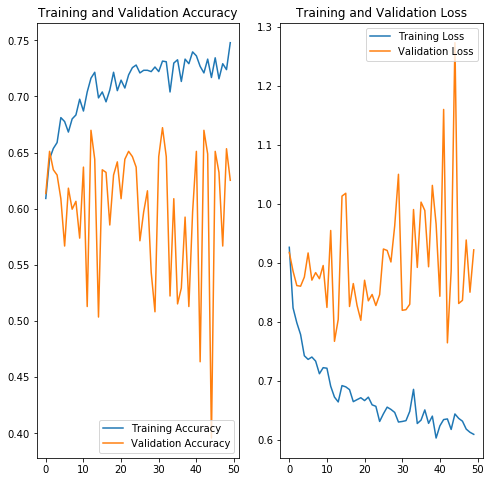

In [5]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 3.2 VGG16 Architecture

In [8]:
IMG_SHAPE = 224
image_gen = ImageDataGenerator(rescale=1./255)
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )
val_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=3, activation="softmax"))

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
epochs = 4

history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

Found 1709 images belonging to 3 classes.
Found 427 images belonging to 3 classes.
Epoch 1/4
54/54 [==============================] - 1146s 21s/step - loss: 0.9149 - accuracy: 0.6337 - val_loss: 0.9121 - val_accuracy: 0.6393
Epoch 2/4
54/54 [==============================] - 1299s 24s/step - loss: 0.9113 - accuracy: 0.6401 - val_loss: 0.9121 - val_accuracy: 0.6393
Epoch 3/4
54/54 [==============================] - 1263s 23s/step - loss: 0.9113 - accuracy: 0.6401 - val_loss: 0.9121 - val_accuracy: 0.6393
Epoch 4/4
54/54 [==============================] - 1151s 21s/step - loss: 0.9113 - accuracy: 0.6401 - val_loss: 0.9121 - val_accuracy: 0.6393


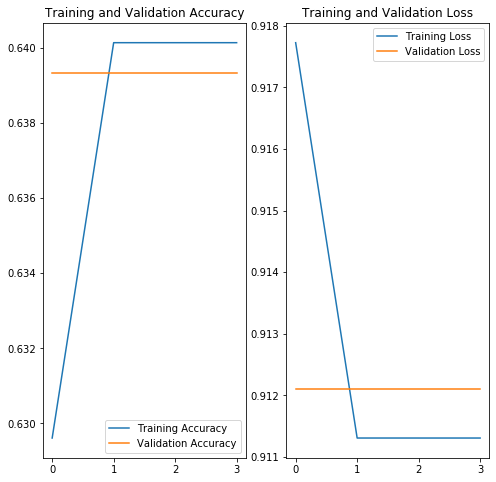

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: vgg/assets


In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

model.save("Hvgg.h5")

model.save("vgg")


# 4 Deploying the Model

In [8]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)


INFO:tensorflow:Assets written to: /tmp/tmpcs5muvjq/assets


INFO:tensorflow:Assets written to: /tmp/tmpcs5muvjq/assets


[[-0.22550108]]


## 4.1 Prediction example

In [5]:
folder = "/home/miguel/Desktop/AUV_dataset/01-05-18/"
for i in range(0,100):
    img_path= folder+random.choice(os.listdir(folder))

Normal NN - H5 format
Time elapsed loading model: 0.11820650100708008
Image below belongs to class  0  with  100.0 % certainty.
Time elapsed: 3.3970773220062256
SaveModel format
Time elapsed loading model: 0.3735496997833252
Image below belongs to class  0  with  100.0 % certainty.
Time elapsed: 3.209290027618408
VGG NN - H5 format
Time elapsed loading model: 3.0632026195526123
Image below belongs to class  1  with  57.61169195175171 % certainty.
Time elapsed: 20.175583362579346
SaveModel format
Time elapsed loading model: 0.3536379337310791
Image below belongs to class  0  with  100.0 % certainty.
Time elapsed: 3.249851703643799


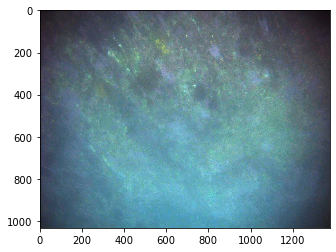

In [6]:
def predict(img_file,size):
  img = tf.keras.preprocessing.image.load_img(img_file, target_size=(size, size))
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)
  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  #print (predictions)
  #print(test_ds.class_names[np.argmax(score)],", ",100 * np.max(score))
  #return (test_ds.class_names[np.argmax(score)],100 * np.max(score))
  return (np.argmax(score), 100 * np.max(score))
  
 
print("Normal NN - H5 format")
start = time.time()
model = load_model("Hmodel22.h5")
end = time.time()
print("Time elapsed loading model: " + str(end - start))

start = time.time()

for i in range(0,100):
    eunis, certainty = predict(img_path,64)
    
print("Image below belongs to class ", eunis, " with ", certainty, "% certainty.")
end = time.time()
print("Time elapsed: " + str(end - start))

print("SaveModel format")
start = time.time()
model = tf.keras.models.load_model("model22")
end = time.time()
print("Time elapsed loading model: " + str(end - start))

start = time.time()

for i in range(0,100):
    eunis, certainty = predict(img_path,64)
    
print("Image below belongs to class ", eunis, " with ", certainty, "% certainty.")
end = time.time()
print("Time elapsed: " + str(end - start))


print("VGG NN - H5 format")
start = time.time()
model = load_model("Hvgg.h5")
end = time.time()
print("Time elapsed loading model: " + str(end - start))

start = time.time()

for i in range(0,100):
    eunis, certainty = predict(img_path,224)
    
print("Image below belongs to class ", eunis, " with ", certainty, "% certainty.")
end = time.time()
print("Time elapsed: " + str(end - start))

print("SaveModel format")
start = time.time()
model = tf.keras.models.load_model("model22")
end = time.time()
print("Time elapsed loading model: " + str(end - start))

start = time.time()

for i in range(0,100):
    eunis, certainty = predict(img_path,64)
    
print("Image below belongs to class ", eunis, " with ", certainty, "% certainty.")
end = time.time()
print("Time elapsed: " + str(end - start))
img=mpimg.imread(img_path)
plt.imshow(img)

In [ ]:
print("Normal NN - tflite")
start = time.time()
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

end = time.time()
print("Time elapsed loading model: " + str(end - start))

start = time.time()

for i in range(0,100):
    # Test the model on random input data.
    input_shape = input_details[0]['shape']
    input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    #print(output_data)
 
end = time.time()
print("Time elapsed: " + str(end - start))

print("VGG NN - tflite")
start = time.time()
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="modelVGG.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

end = time.time()
print("Time elapsed loading model: " + str(end - start))

start = time.time()

for i in range(0,100):
    # Test the model on random input data.
    input_shape = input_details[0]['shape']
    input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    #print(output_data)
 
end = time.time()
print("Time elapsed: " + str(end - start))


## 4.2 Full example

In [2]:
base_dir = "/home/miguel/Desktop/AUV_dataset/01-05-18/"
classes = ['A3', 'A4', 'A5']
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

IMG_SHAPE = 64
batch_size = 32

image_gen = ImageDataGenerator(rescale=1./255)
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )
val_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

model = Sequential()
model.add(Conv2D(input_shape=(IMG_SHAPE,IMG_SHAPE,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=3, activation="softmax"))

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
epochs = 10

history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

model.save("VGGAS")

Found 1709 images belonging to 3 classes.
Found 427 images belonging to 3 classes.
Epoch 1/10
54/54 [==============================] - 164s 3s/step - loss: 0.9113 - accuracy: 0.6331 - val_loss: 0.9121 - val_accuracy: 0.6393
Epoch 2/10
54/54 [==============================] - 170s 3s/step - loss: 0.9113 - accuracy: 0.6401 - val_loss: 0.9121 - val_accuracy: 0.6393
Epoch 3/10
54/54 [==============================] - 149s 3s/step - loss: 0.9113 - accuracy: 0.6401 - val_loss: 0.9121 - val_accuracy: 0.6393
Epoch 4/10
54/54 [==============================] - 134s 2s/step - loss: 0.9113 - accuracy: 0.6401 - val_loss: 0.9121 - val_accuracy: 0.6393
Epoch 5/10
54/54 [==============================] - 175s 3s/step - loss: 0.9113 - accuracy: 0.6401 - val_loss: 0.9121 - val_accuracy: 0.6393
Epoch 6/10
54/54 [==============================] - 170s 3s/step - loss: 0.9113 - accuracy: 0.6401 - val_loss: 0.9121 - val_accuracy: 0.6393
Epoch 7/10
54/54 [==============================] - 180s 3s/step - loss

ResourceExhaustedError: VGGAS/variables/variables_temp_ba9bc389ced04572a5ef3b64f175f200/part-00000-of-00001.data-00000-of-00001.tempstate18299049361831111133; No space left on device [Op:SaveV2]

In [4]:
converter = tf.lite.TFLiteConverter.from_saved_model("/home/miguel/Desktop/Auv Code/model/VGGAS")
tflite_model = converter.convert()

# Save the model.
with open('VGGAS.tflite', 'wb') as f:
  f.write(tflite_model)

In [3]:
model.save("VGGAS.h5")
model.save("VGGAS")

INFO:tensorflow:Assets written to: VGGAS/assets


# 5 Architecture

## 5.1 IMC

Inter-Module Communications is a message-oriented language where messages can be nested into one or more message concepts. This messages are transmitted asynchronously with mechanisms for discovery and broadcast where they are either added to local protocols or merged with centralized definitions. IMC describes how a peer can announce itself by means of messages sent out. It is considered transport-agnostic since it defines adressing, serialization and discovery so it cannot rely on transport-specific addresses like IP or radio frequencies. Instead defines an addressing scheme to be used by all systems and conveyed in all top-level messages. IMC protocol is defined in XML with fixed adresses, field types and messages and from the XML definitions automatically generates its documentation explaining how to serialize each of the messages, its meaning and programming APIs. 

## 5.2 Dune

Dune Uniform Navigation Environment is a onboard software for unmanned vehicles that deals with communications with outside world, sensing and actuation, navigation, control and logging. Its mostly built using c++ code and CMake for cross compilation, its efficient, portable and flexible. It is divided into Tasks that run in different threads, communicate asynchronously and there is no shared memory however, if one task crashes, DUNE crashes. It also does not require IPC increasing efficiency. This tasks respond to inputs by changing its state and interacting with other Tasks, emmiting outputs. When Dune starts, the Daemon load a platform configuration that instantiates all Task that are referred in the configuration, sets the provided configuration, starts a new thread for each of the tasks and then interact with one another asynchronously using an IMC bus. Dune transports translate messages between IMC and other medium.


## 5.3 Overall

Our framework depend on both dune and imc. For our tests we started by simulating a LAUV with dune so that we can have communication. Once the simulation is running, we start the main program which defines the vehicle early on so that it can be mapped to a communicator. Here we defined three different stages, one for the set-up of values, starting the image classification process and stop action. These actions are changed via a flag which is delivered through a IMC message exchanged (ImageClassificationControl) from dune-send-msg that also sends the tflite model and its labels, frequency of frame classification and video source that can be a video file or a camera that is transmitting live frames. So starting with the 2 flag we transfer the arguments in dune-send-msg to the main program, for the 0 we start looping infinitely and grabbing frames depending on our frequency setting, then we classify our frame with the model and the labels defined previously. Once we are done we create two different IMC messages Image Classification and Image Score, the second is a field of the first as a message list and we fill these message fields with the classification information at the end we send this message to our vehicle that can be simulated. 